# Entrenamiento de modelo detector con YOLOv7 (PyTorch)

Este cuaderno contiene los pasos para entrenar un modelo YOLOv7 en PyTorch y exportar para inferencia con Triton Server.

**Entradas**:

- Dataset para detección de objetos con YOLOv7

**Salidas**:

- Modelo YOLOv7 entrenado en PyTorch (`.pt`).
- Modelo exportado para inferencia en Triton Server.

**Resumen del procedimiento**

1. Descarga de YOLOv7 e instalación de dependencias.
2. Descarga y preparación de dataset.
3. Entrenamiento.
4. Evaluación.
5. Inferencia.
6. Despliegue con Triton Server.

**Referencias**

- [Official YOLOv7](https://github.com/WongKinYiu/yolov7)

## 1. Descarga de YOLOv7 e instalación de dependencias

Este cuaderno asume que se ejecuta en un ambiente donde YOLOv7 Aún no ha sido instalado. 

Se descargará en el subdirectorio `yolov7`. La mayorìa de los pasos que siguen se ejecutan adentro del mismo.

In [1]:
import os
if not os.path.exists('yolov7'):
    !git clone https://github.com/WongKinYiu/yolov7.git

In [44]:
# Asegurarse de estar adentro de yolov7
cwd=%pwd
if cwd.split('/')[-1] != 'yolov7':
    %cwd yolov7

In [ ]:
!pip install -r requirements.txt

## 2. Descarga y preparación de dataset

### Dataset de ejemplo: Pothole

Fuente: [Fine Tuning YOLOv7 on Custom Dataset](https://learnopencv.com/fine-tuning-yolov7-on-custom-dataset/)

In [11]:
# Asegurarse de estar adentro de yolov7
cwd=%pwd
if cwd.split('/')[-1] != 'yolov7':
    %cwd yolov7

In [12]:
import os
if not os.path.exists('pothole_dataset.zip'):
    !wget https://learnopencv.s3.us-west-2.amazonaws.com/pothole_dataset.zip
    !unzip -q pothole_dataset.zip

Estructura de directorios de dataset de entrada.    

In [13]:
!tree -d pothole_dataset | head -n 20

pothole_dataset
├── images
│   ├── test
│   ├── train
│   └── valid
└── labels
    ├── test
    ├── train
    └── valid

8 directories


In [15]:
!ls pothole_dataset/images/train | head -n 5

G0010033.JPG
G0010117.JPG
G0010119.JPG
G0010121.JPG
G0010122.JPG
ls: write error: Broken pipe


In [16]:
!ls pothole_dataset/labels/train | head -n 5

G0010033.txt
G0010117.txt
G0010119.txt
G0010121.txt
G0010122.txt
ls: write error: Broken pipe


In [17]:
!cat pothole_dataset/labels/train/G0010033.txt

0 0.5497282608695652 0.5119565217391304 0.017934782608695653 0.005072463768115942
0 0.41032608695652173 0.5253623188405797 0.025 0.005797101449275362
0 0.30842391304347827 0.5282608695652173 0.014673913043478261 0.005797101449275362
0 0.1654891304347826 0.5224637681159421 0.027717391304347826 0.005797101449275362
0 0.10163043478260869 0.5286231884057971 0.01956521739130435 0.006521739130434782
0 0.07907608695652174 0.5293478260869565 0.01576086956521739 0.007971014492753623


Formato: 

~~~
class, x_center, y_center, width, height
~~~

### Definición del dataset

Debe ir en `yolov7/data`.

In [18]:
# Asegurarse de estar adentro de yolov7
cwd=%pwd
if cwd.split('/')[-1] != 'yolov7':
    %cwd yolov7

In [19]:
%%writefile data/pothole.yaml
train: ../pothole_dataset/images/train
val: ../pothole_dataset/images/valid
test: ../pothole_dataset/images/test

# Classes
nc: 1  # number of classes
names: ['pothole']  # class names

Overwriting data/pothole.yaml


In [20]:
!cat data/pothole.yaml

train: ../pothole_dataset/images/train
val: ../pothole_dataset/images/valid
test: ../pothole_dataset/images/test

# Classes
nc: 1  # number of classes
names: ['pothole']  # class names


## 2. Configuración del modelo

In [21]:
# Asegurarse de estar adentro de yolov7
cwd=%pwd
if cwd.split('/')[-1] != 'yolov7':
    %cwd yolov7

In [22]:
!ls cfg/training

yolov7-d6.yaml	 yolov7-e6.yaml       yolov7-tiny.yaml	yolov7x.yaml
yolov7-e6e.yaml  yolov7_pothole.yaml  yolov7-w6.yaml	yolov7.yaml


In [23]:
!cat cfg/training/yolov7.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov7 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
  
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2      
   [-1, 1, Conv, [64, 3, 1]],
   
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4  
   [-1, 1, Conv, [64, 1, 1]],
   [-2, 1, Conv, [64, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],  # 11
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 16-P3/8  
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],

<div class="alert alert-warning">
Atención: editar manualemnte este archivo luego de copiar.
</div>

In [10]:
!cp cfg/training/yolov7.yaml cfg/training/yolov7-pothole.yaml

## 3. Entrenamiento

In [24]:
# Asegurarse de estar adentro de yolov7
cwd=%pwd
if cwd.split('/')[-1] != 'yolov7':
    %cwd yolov7

Descargar pesos iniciales.

In [25]:
import os
if not os.path.exists('yolov7_training.pt'): 
    !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

Verificar disponibilidad de GPU(s).

In [26]:
!nvidia-smi

Sun Aug 28 09:11:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   34C    P8    15W /  N/A |   1313MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Si se dispone de recursos se puede aumentar el número de workers y tamaño de batch. En una laptop con RTX3070MQ funcionó sólo con `workers=1` y `batch-size=4`.

Se puede monitorear el entrenamiento con Tensorboard.

En una terminal aparte:

~~~bash
tensorboard --logdir runs/train
~~~

Tensorboard:  http://localhost:6006/

In [15]:
!python train.py --epochs 100 \
                 --workers 1 \
                 --device 0 \
                 --batch-size 4 \
                 --data data/pothole.yaml \
                 --img 640 640 \
                 --cfg cfg/training/yolov7_pothole.yaml \
                 --weights 'yolov7_training.pt' \
                 --name yolov7_pothole \
                 --hyp data/hyp.scratch.custom.yaml

YOLOR 🚀 v0.1-107-g44d8ab4 torch 1.12.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7982.3125MB)

Namespace(weights='yolov7_training.pt', cfg='cfg/training/yolov7_pothole.yaml', data='data/pothole.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=100, batch_size=4, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=1, project='runs/train', entity=None, name='yolov7_pothole', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], world_size=1, global_rank=-1, save_dir='runs/train/yolov7_pothole8', total_batch_size=4)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, war

In [49]:
!ls runs/train/yolov7_pothole

events.out.tfevents.1661640234.nhorropc.32799.0  hyp.yaml  opt.yaml  weights


## 4. Evaluación

In [21]:
!python test.py --data data/pothole.yaml \
               --img 640 \
               --batch 32 \
               --conf 0.001 \
               --iou 0.65 \
               --device 0 \
               --weights runs/train/yolov7_pothole8/weights/best.pt \
               --name yolov7_640_val

Namespace(weights=['runs/train/yolov7_pothole8/weights/best.pt'], data='data/pothole.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='yolov7_640_val', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-107-g44d8ab4 torch 1.12.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7982.3125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/home/nhorro/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 

In [22]:
!ls runs/test/yolov7_640_val

confusion_matrix.png  R_curve.png	      test_batch1_pred.jpg
F1_curve.png	      test_batch0_labels.jpg  test_batch2_labels.jpg
P_curve.png	      test_batch0_pred.jpg    test_batch2_pred.jpg
PR_curve.png	      test_batch1_labels.jpg


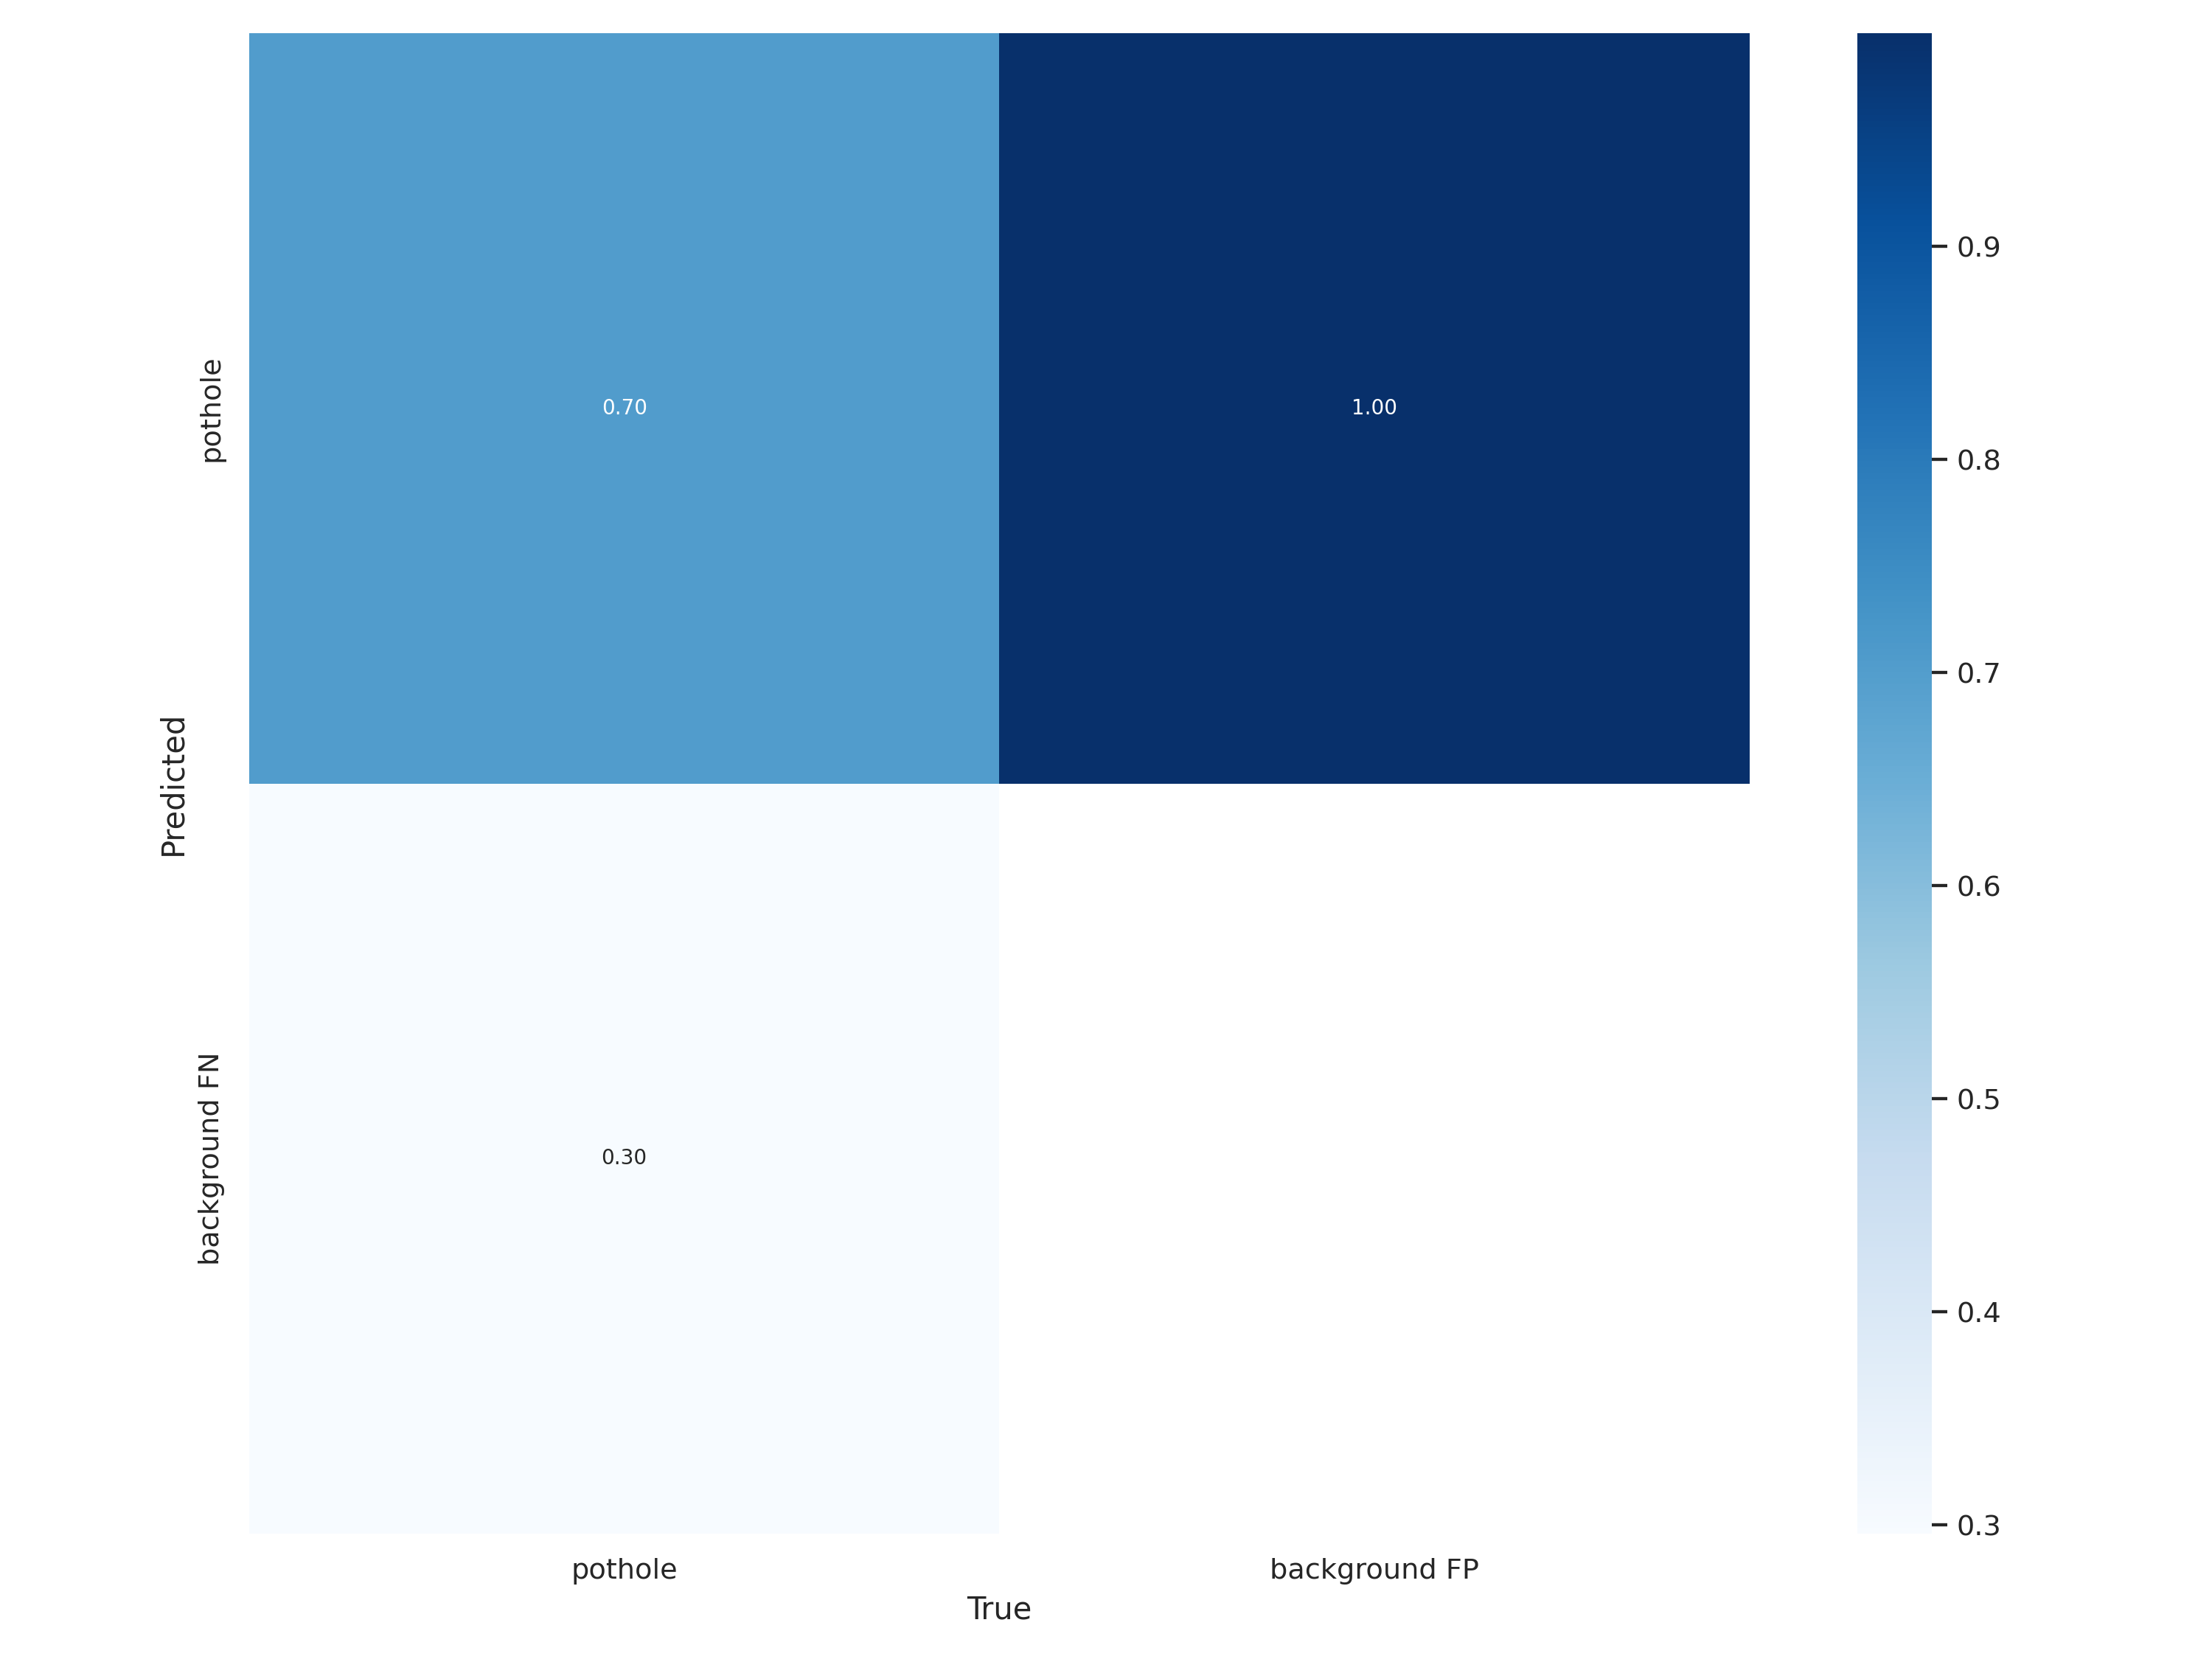

In [27]:
from IPython.display import display, Image
display(Image(filename='runs/test/yolov7_640_val/confusion_matrix.png',width=600,height=600))

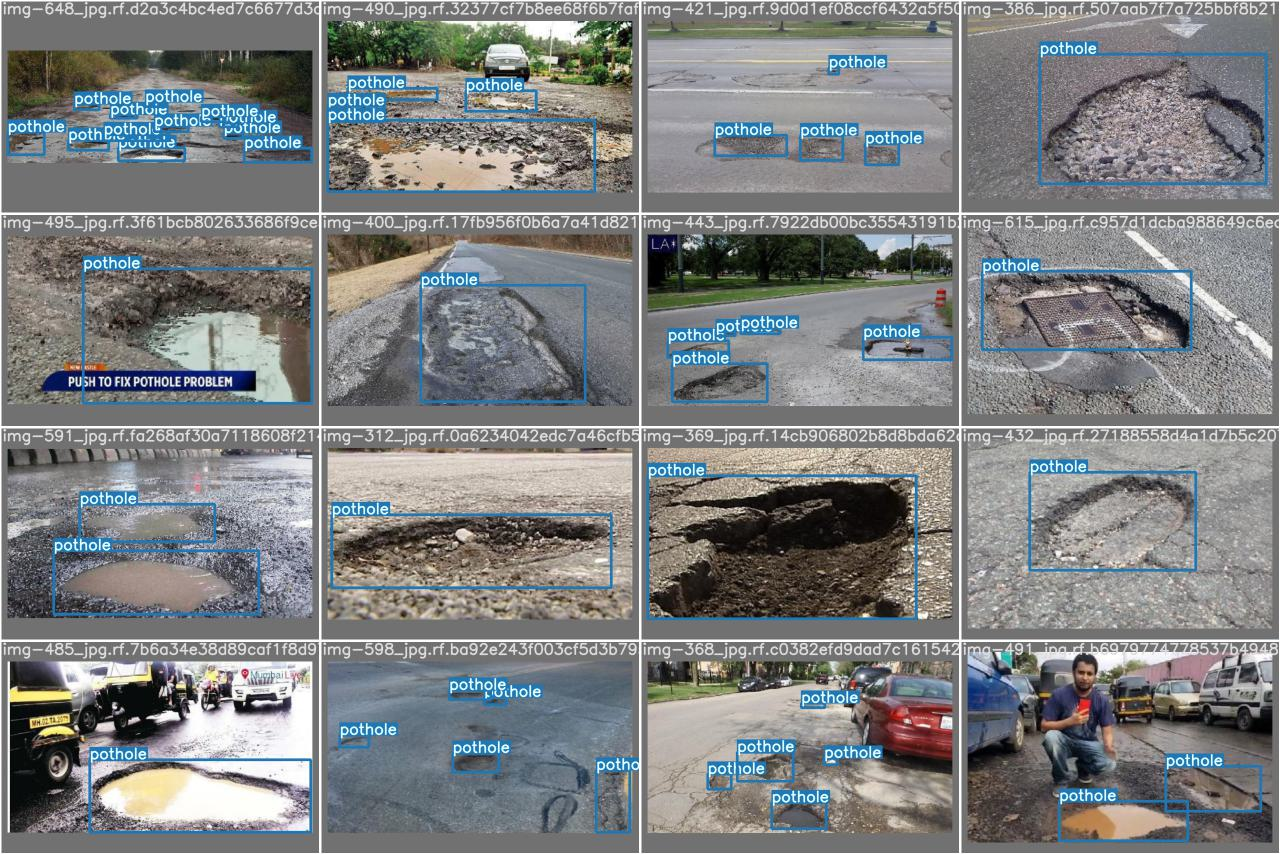

In [30]:
display(Image(filename='runs/test/yolov7_640_val/test_batch0_labels.jpg',width=1024,height=1024))

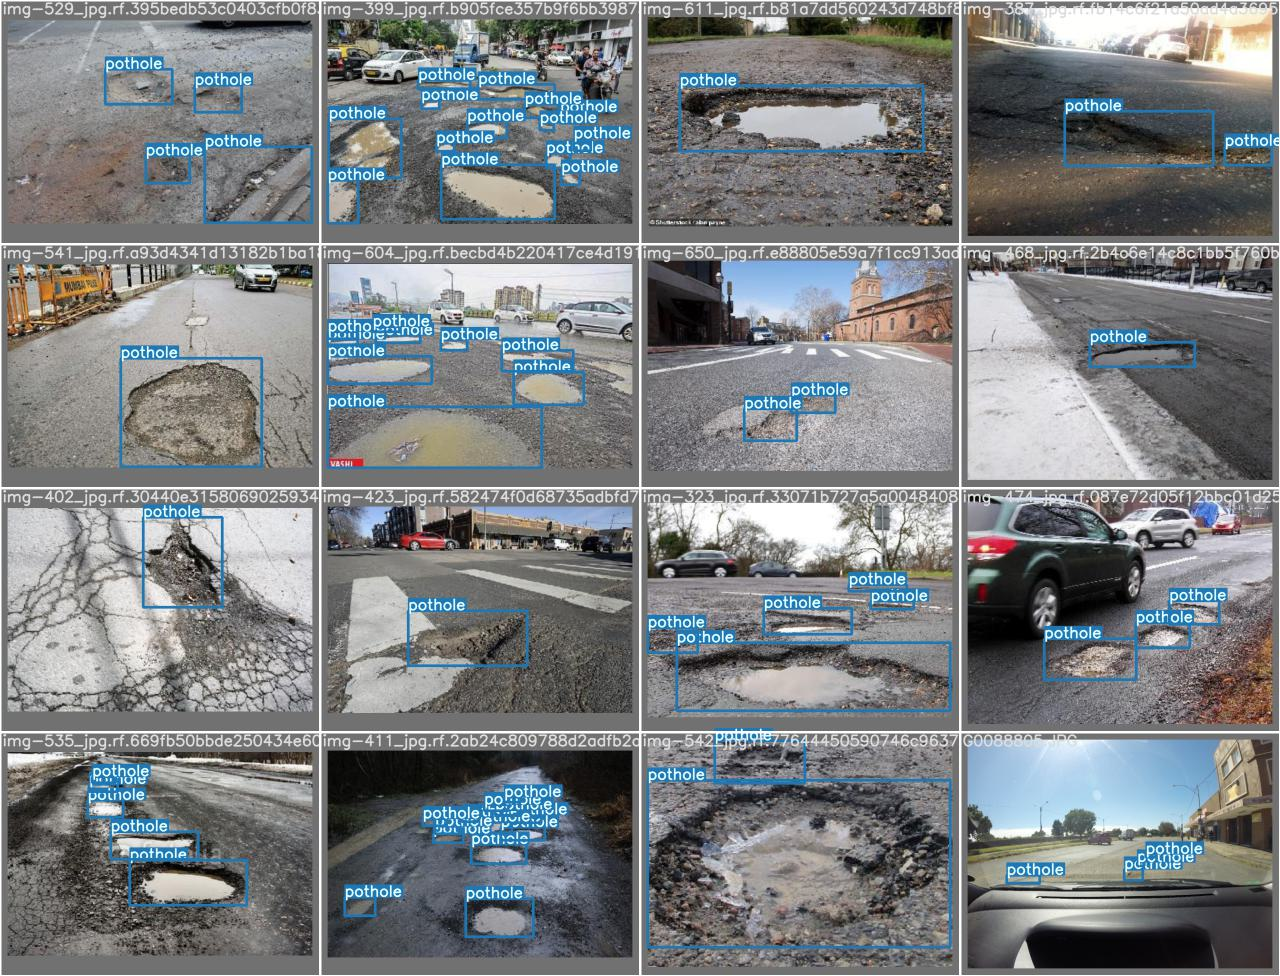

In [31]:
display(Image(filename='runs/test/yolov7_640_val/test_batch1_labels.jpg',width=1024,height=1024))

## 5. Inferencia (PyTorch)

In [31]:
%pwd

'/home/nhorro/workspace/learn-pytorch/yolov7'

In [36]:
!ls runs/train/yolov7_pothole8/weights

best.pt       epoch_024.pt  epoch_074.pt  epoch_096.pt	epoch_098.pt  init.pt
epoch_000.pt  epoch_049.pt  epoch_095.pt  epoch_097.pt	epoch_099.pt  last.pt


In [42]:
import torch
from torchvision import transforms
import numpy as np

MODEL_WEIGHTS_PATH="runs/train/yolov7_pothole8/weights/best.pt"
MODEL_WEIGHTS_PATH="runs/train/yolov7_pothole8/weights/best.pt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load(MODEL_WEIGHTS_PATH)
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

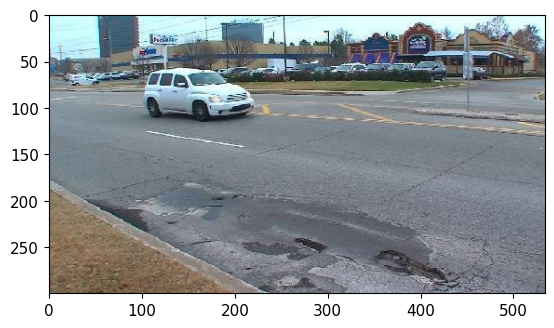

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

TEST_IMG_PATH='pothole_dataset/images/test/img-294_jpg.rf.a16953e9091e3eecfc338ed3044ef294.jpg'
img = cv2.imread(TEST_IMG_PATH) 
img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [70]:
image = img.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()
with torch.no_grad():
    output, _ = model(image)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 38 but got size 37 for tensor number 1 in the list.

## 6. Despliegue con Triton Server

In [39]:
1
import matplotlib.pyplot as plt
2

3
import cv2
4

5
import time
6
 
7

8
from utils.datasets import letterbox
9
from utils.general import non_max_suppression_kpt
10
from utils.plots import output_to_keypoint, plot_skeleton_kpts
11
 
12

13

14

15

16



import torch



# Load
model = torch.load(MODEL_PATH)

In [40]:
model.summary()

AttributeError: 'dict' object has no attribute 'summary'